# Importing relevent libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

## Loading Dataset

In [2]:
data = pd.read_csv('/content/age_gender.csv')

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [3]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 6677
Total columns: 5


## Distributions

In [4]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

## Age Distribtion

In [5]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

## Ethnicity Distribution

In [6]:

ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

## Gender Distribution

In [7]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

In [12]:
data['pixels_len'] = data['pixels'].apply(len)
# Filter out rows where the pixel array length is not 48*48
data_filtered = data[data['pixels_len'] == 48*48]

X = np.stack(data_filtered['pixels'].values).astype('float32')

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

## Sample Images

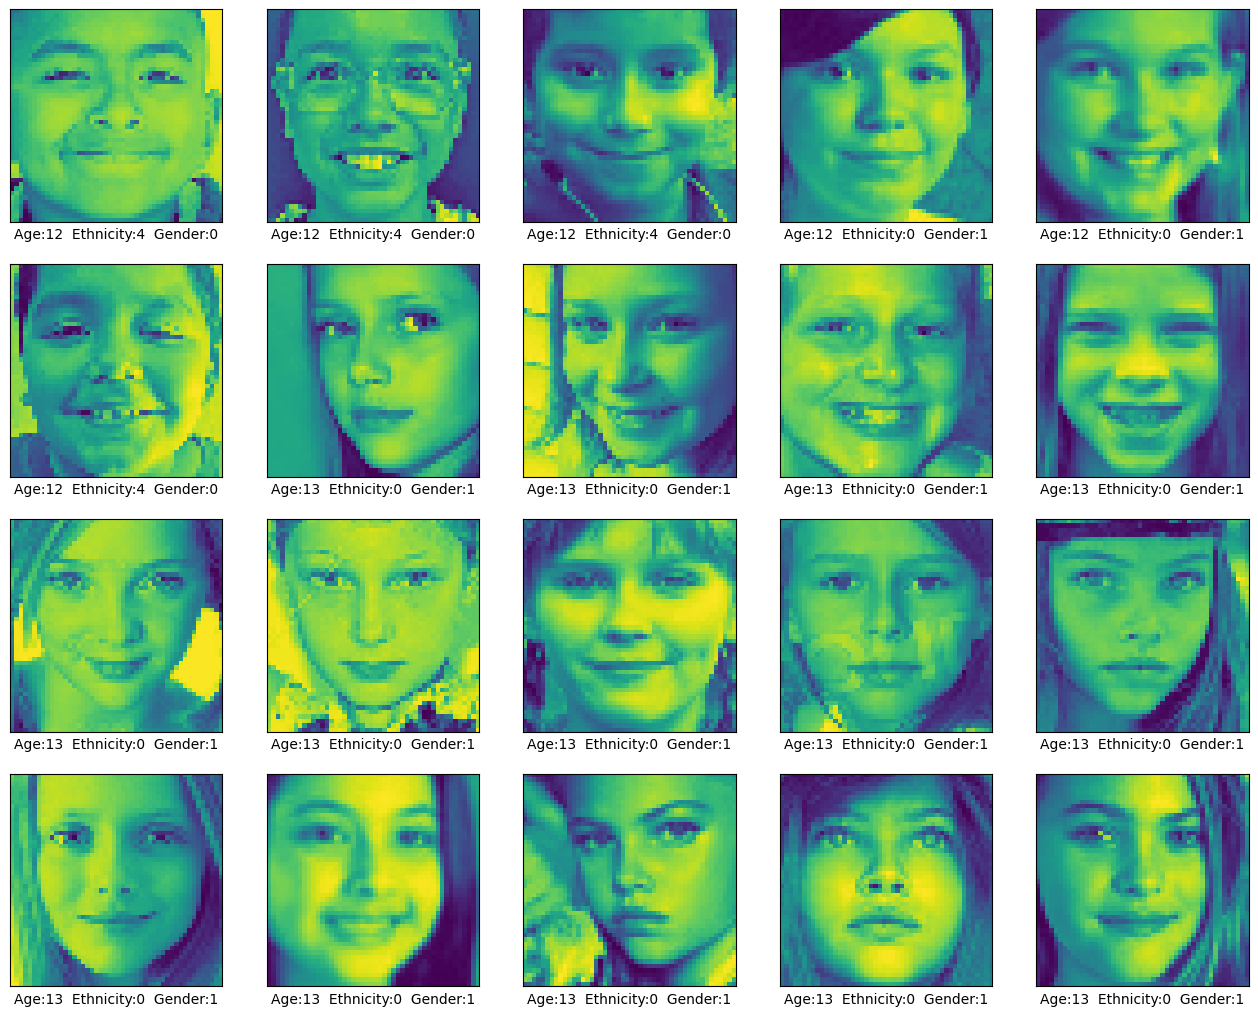

In [13]:
plt.figure(figsize=(16,16))
for i in range(1500,1520):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )
plt.show()

## Model for Gender Prediction

In [15]:
y = data_filtered['gender']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### **Build and train** **model**

In [17]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='sigmoid')
])

model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True

callback = myCallback()

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,673 (1.64 MB)

 Trainable params: 428,609 (1.64 MB)

 Non-trainable params: 64 (256.00 B)

In [18]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 225ms/step - accuracy: 0.6032 - loss: 0.6480 - val_accuracy: 0.6238 - val_loss: 0.6876
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.6942 - loss: 0.5760 - val_accuracy: 0.6123 - val_loss: 0.6529
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.7207 - loss: 0.5432 - val_accuracy: 0.7217 - val_loss: 0.6300
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.7412 - loss: 0.5062 - val_accuracy: 0.7428 - val_loss: 0.6154
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.7662 - loss: 0.4767 - val_accuracy: 0.7639 - val_loss: 0.5635
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.7829 - loss: 0.4484 - val_accuracy: 0.7524 - val_loss: 0.5233
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.7900 - loss: 0.4314 - val_accuracy: 0.7716 - val_loss: 0.5064
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.7954 - loss: 0.4237 - val_accu

## Evaluate training history

In [19]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'},
    title='Training History')
fig.show()

In [20]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.4345281720161438
Test Accuracy: 0.779441773891449


## Model for Ethnicity Prediction

In [22]:
y = data_filtered['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### **Build and train model**

In [23]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(5)
])

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Stop training when validation accuracy reach 79%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.790):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()


model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,805 (1.64 MB)

 Trainable params: 428,805 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(
    X_train, y_train, epochs=18, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/18
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.2946 - loss: 1.5610 - val_accuracy: 0.3916 - val_loss: 1.4371
Epoch 2/18
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.3969 - loss: 1.4426 - val_accuracy: 0.5432 - val_loss: 1.2757
Epoch 3/18
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.5137 - loss: 1.2474 - val_accuracy: 0.6200 - val_loss: 1.1180
Epoch 4/18
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.5687 - loss: 1.1446 - val_accuracy: 0.6488 - val_loss: 1.0223
Epoch 5/18
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.6051 - loss: 1.0725 - val_accuracy: 0.6142 - val_loss: 0.9866
Epoch 6/18
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.6380 - loss: 0.9908 - val_accuracy: 0.6507 - val_loss: 0.9800
Epoch 7/18
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.6463 - loss: 0.9465 - val_accuracy: 0.6910 - val_loss: 0.8750
Epoch 8/18
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.6610 - loss: 0.9197 - val_accu

### Evaluate training history

In [25]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'},
    title='Training History')
fig.show()

In [26]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.768292248249054
Test Accuracy: 0.7338325381278992


## Model for Age prediction

In [28]:
y = data_filtered['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model

In [30]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


## Stop training when validation loss reach 110
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True

callback = myCallback()


model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,001 (875.00 KB)

 Trainable params: 223,937 (874.75 KB)

 Non-trainable params: 64 (256.00 B)

In [31]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - loss: 160.5755 - mae: 9.2155 - val_loss: 361.4964 - val_mae: 15.1618
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - loss: 90.1369 - mae: 6.0457 - val_loss: 325.2174 - val_mae: 14.2434
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - loss: 79.4108 - mae: 5.6103 - val_loss: 265.0227 - val_mae: 12.5903
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - loss: 75.3676 - mae: 5.4057 - val_loss: 249.9335 - val_mae: 12.1382
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - loss: 57.0553 - mae: 4.6711 - val_loss: 202.1625 - val_mae: 10.6025
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - loss: 58.1520 - mae: 4.7173 - val_loss: 187.1562 - val_mae: 10.0930
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 64.1495 - mae: 5.0897
Reached 110 val_loss so cancelling training!
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - loss: 64.0866 - mae: 5.0869 - val_loss: 95.0150 - val_mae: 6.0624


### Evaluate training history

In [32]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'},
    title='Training History')
fig.show()


In [33]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

Test Mean squared error: 73.68907928466797
Test Mean absolute error: 5.821430683135986
